# Case Study: ProPublica's Analysis of the COMPAS Tool

Goal: Be introduced into the topic of fairness by following a ProPublica published analysis of the COMPAS tool. The article was referenced in a Ethics of Machine Learning and Data Science undergraduate course. This notebook's template was recreated for further practice. 

Article: https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Data Collection: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

COMPAS stands for Correctional Offender Management Profiling for Alternative Sanctions. It's a proprietary tool which generates a risk score for trial defendants. 
The published article focuses on the recidivism score, which states to provide the likelihood of recidivism within two years of defendant assessment. 

ProPublica focused on racial bias in the COMPAS algorithm. In general terms, ProPublica analyzed (i) how the *risk scores* vary by race and (ii) the extent to which the *risk labels* assigned to defendants matches up with their observed recidivism and how this varies by race. We will (approximately) reproduce this analysis below.

The process of following along the ProPublica analysis will be to 
1. Import the data, pre-process the data
2. Exploratory data analysis
3. Analysis of COMPAS recidivism score which is our primary variable of focus, and how it scales with attributes like race and sex. 
4. Reproduce the report's logistic regression model 
5. Compute predictive accuracy of the risk labels. 



In [1]:
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import from ProPublica's compas-analysis repository on GitHub and check the first few rows
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)
print("Shape: ", df_compas.shape)
df_compas.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


# Inspect Data

Variable definitions are as follows:

| Variable    | Description |
| ----------- | ----------- |
| age       |  Age of the defendant   |
| age_cat   |  Age category. It can be < 25, 25-45, >45    |
| sex   |  Sex of the defendant. It is either "Male" or "Female"       |
| race   |  Race of the defendant. It can be "African-American", "Caucasian", "Hispanic", "Asian", or "Other"      |
| c_charge_degree   |   Charge. Either "M" for misdemeanor, "F" for felony, or "O" (not causing jail time)    |
| priors_count   |   Count of prior crimes committed by the defendant      |
| days_b_screening_arrest   |  Days between the arrest and COMPAS screening       |
| decile_score   |  The COMPAS score estimated by the system. It is between 0-10       |
| score_text   |  Decile score. It can be "Low" (1-4), "Medium" (5-7), or "High" (8-10)       |
| is_recid   |  Indicates if the defendant recidivated. It can be 0, 1, or -1      |
| two_year_recid   |  Indicates if the defendant recidivated within two years of COMPAS assessment      |
| c_jail_in   |   Date the defendant was in jail      |
| c_jail_out  |   Date when the defendant was released from jail     |


### First, we'll plot the distribution of our focus variables of age, race, and sex

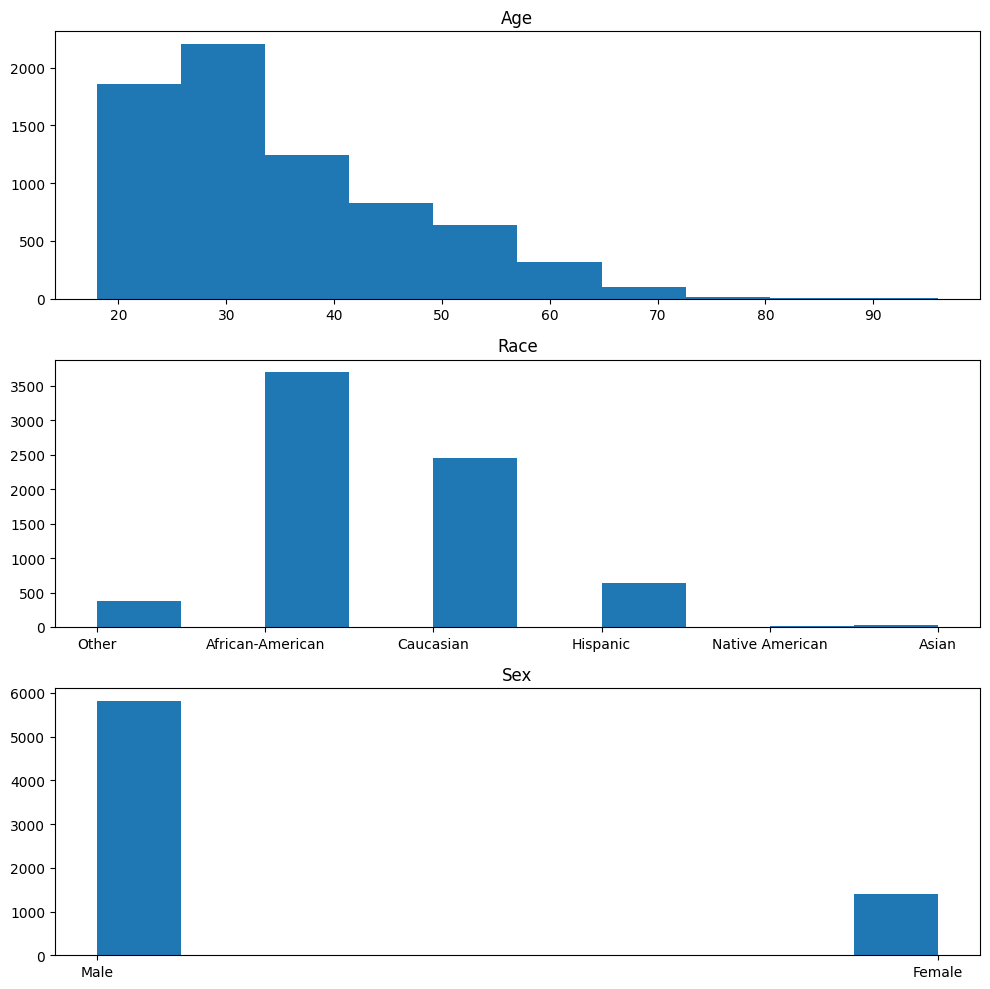

In [3]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10))
ax1.hist(df_compas.age)
ax1.set_title('Age')
ax2.hist(df_compas.race)
ax2.set_title('Race')
ax3.hist(df_compas.sex)
ax3.set_title('Sex')

plt.rcParams['text.color'] = 'Green'
plt.rcParams['axes.labelcolor'] = 'Green'
plt.rcParams['xtick.color'] = 'Green'
plt.rcParams['ytick.color'] = 'Green'

plt.tight_layout()

### Pre-processing: 

ProPublica first generated a subset of data with variables of interest. 

In our case, we'll keep it even simpler. 

In [9]:
# Preprocess Data
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]
df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])
df_selected = df_compas[cols_to_keep].copy()

print("Shape: ", df_selected.shape)
df_selected.head()

Shape:  (7214, 12)


,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
3,5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0
4,6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0


ProPublica filtered the above data by removing rows where:

1. The COMPAS score is missing.
1. If COMPAS-scored crime was not within 30 days from the date of arrest, ProPublica assumed that the offense may not be correct.
2. The recividist flag is "-1". In such cases, ProPublica could not find a COMPAS record at all.
3. The charge is "O". These are ordinary traffic offenses and do not result in jail time.

Note: The report only includes people who had recidivated within two years or had at least two years outside a correctinal facility. This step is already completed before ProPublica released this dataset. 

We implement these conditions here:

In [10]:
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

In [11]:
# check the number of variables and observations in df_compas and df_analysis here
print('df_compas shape (observations, variables): ', df_compas.shape)
print('df_analysis shape (observations, variables): ', df_analysis.shape)

df_compas shape (observations, variables):  (7214, 53)
df_analysis shape (observations, variables):  (6172, 12)


# Inspect Data Again

Re-inspect salient variables in the data after the preprocessing steps. Plot the distribution of age, race, and sex in the preprocessed data (```df_analysis```) and compare these distributions to the imported data (```df_compas```):

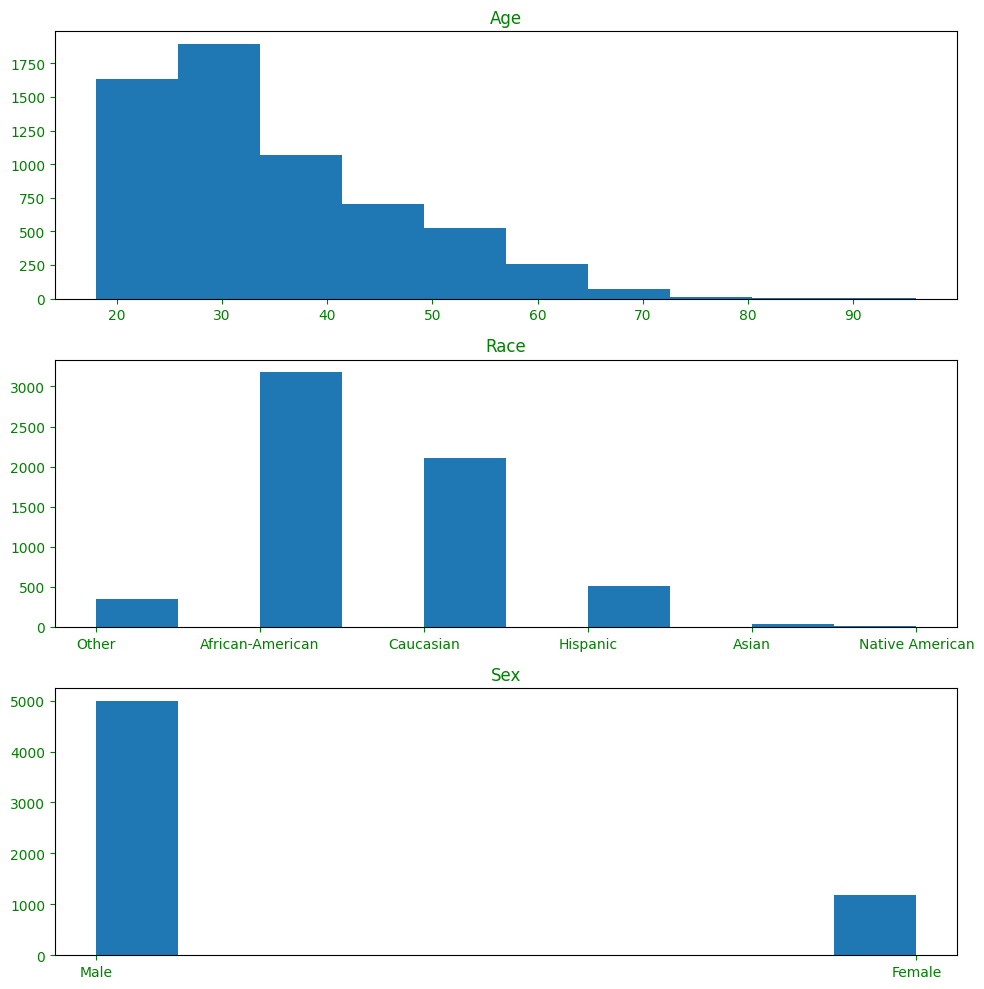

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10))
ax1.hist(df_analysis.age)
ax1.set_title('Age')
ax2.hist(df_analysis.race)
ax2.set_title('Race')
ax3.hist(df_analysis.sex)
ax3.set_title('Sex')

plt.rcParams['text.color'] = 'Green'
plt.rcParams['axes.labelcolor'] = 'Green'
plt.rcParams['xtick.color'] = 'Green'
plt.rcParams['ytick.color'] = 'Green'

plt.tight_layout()

Let's look at the summary of our variables of interset (race and sex):

In [13]:
# generate a crosstab summarizing the number of observations
pd.crosstab(df_analysis.race, df_analysis.sex)

sex,Female,Male
race,,
African-American,549,2626
Asian,2,29
Caucasian,482,1621
Hispanic,82,427
Native American,2,9
Other,58,285


Now let's focus on the COMPAS recidivism score, focusing on the 'decile_score' feature. 

Check the distribution of decile scores across sex. 

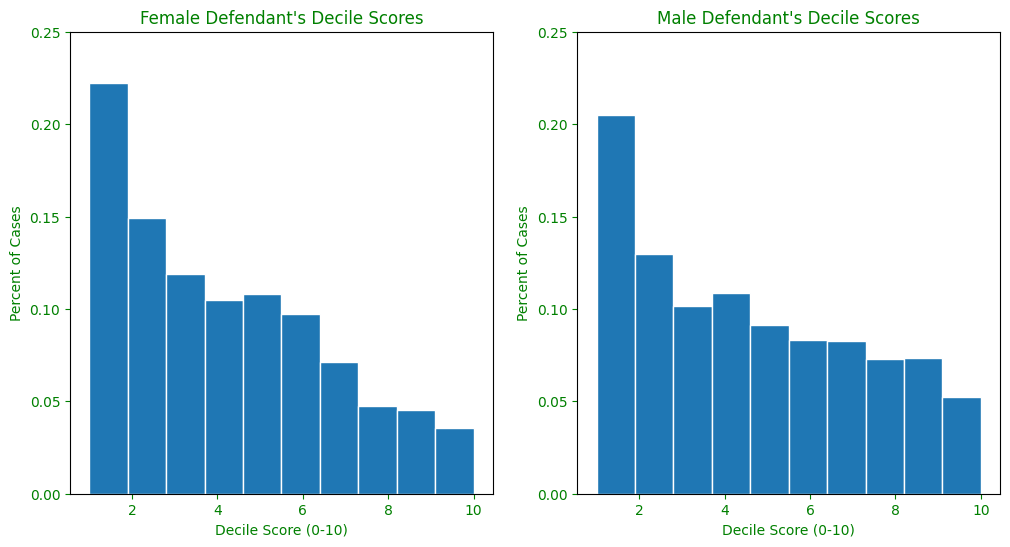

In [14]:
#plot score decile by sex
df_female = df_analysis[(df_analysis.sex == "Female")].copy()
df_male   = df_analysis[(df_analysis.sex == "Male")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_female["decile_score"], ec = "white",
         weights = np.ones(len(df_female["decile_score"])) /
         len(df_female["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Female Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_male["decile_score"], ec = "white",
         weights = np.ones(len(df_male["decile_score"])) /
         len(df_male["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Male Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

Do the same for the 'race' feature.

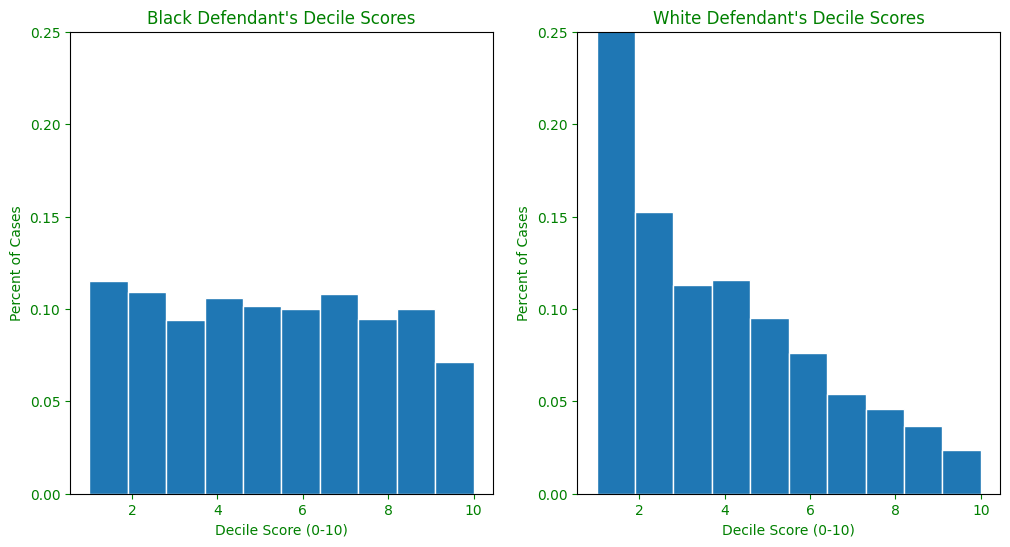

In [15]:
df_black = df_analysis[(df_analysis.race == "African-American")].copy()
df_white   = df_analysis[(df_analysis.race == "Caucasian")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_black["decile_score"], ec = "white",
         weights = np.ones(len(df_black["decile_score"])) /
         len(df_black["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Black Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_white["decile_score"], ec = "white",
         weights = np.ones(len(df_white["decile_score"])) /
         len(df_white["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("White Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

Now we'll plot the distribution of the COMPAS-assigned "risk labels" ("score_text") for Black defendants and White defendants:

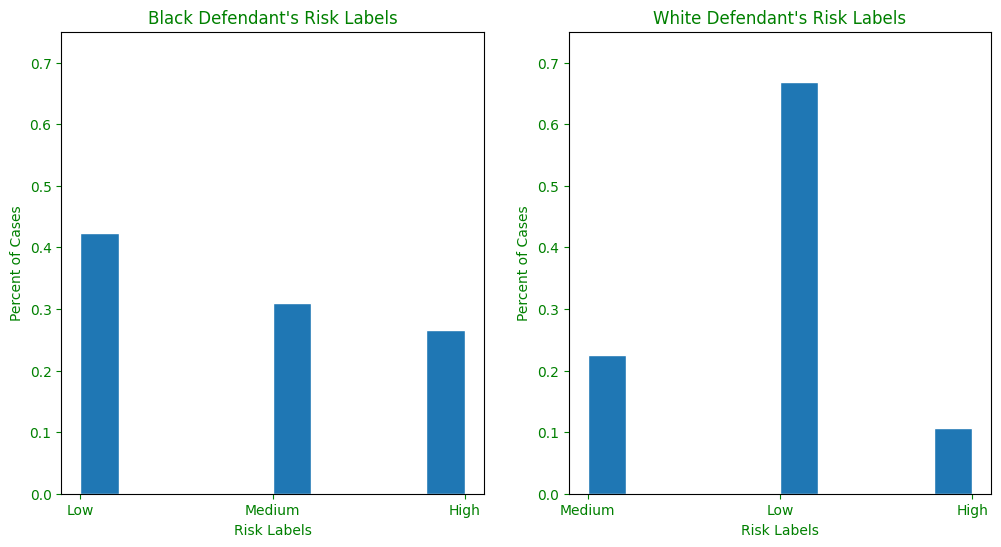

In [16]:
fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_black["score_text"], ec = "white",
         weights = np.ones(len(df_black["score_text"])) /
         len(df_black["score_text"]))
plt.xlabel("Risk Labels")
plt.ylabel("Percent of Cases")
plt.title("Black Defendant's Risk Labels")
plt.ylim([0, 0.75])

fig.add_subplot(122)
plt.hist(df_white["score_text"], ec = "white",
         weights = np.ones(len(df_white["score_text"])) /
         len(df_white["score_text"]))
plt.xlabel("Risk Labels")
plt.ylabel("Percent of Cases")
plt.title("White Defendant's Risk Labels")
plt.ylim([0, 0.75])

plt.show()

Now we'll preprocess the data for logisic regression. 
First, we'll one-hot encode the categorical features. 

In [17]:
# get the feature data types
print(df_analysis.dtypes)

id                           int64
age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
dtype: object


In [18]:
for i, col_type in enumerate(df_analysis.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            df_analysis.columns[i],
            df_analysis[df_analysis.columns[i]].unique()))


Variable c_charge_degree takes the values: ['F' 'M']

Variable race takes the values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Variable age_cat takes the values: ['Greater than 45' '25 - 45' 'Less than 25']

Variable score_text takes the values: ['Low' 'Medium' 'High']

Variable sex takes the values: ['Male' 'Female']


In [22]:
df_logistic = df_analysis.copy()

# one-hot encoding
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# mutate score_text to binary variable where low = {low}
# and high = {medium, high}
df_logistic["score_binary"] = np.where(df_logistic["score_text"] != "Low",
                                       "High", "Low")
df_logistic["score_binary"] = df_logistic["score_binary"].astype('category')

# rename the columns to be more instructive and consistent with statsmodel
# requirements for variable names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)


Check that recoding resulted in the desired data structure:

In [23]:
df_logistic.head()

,id,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,...,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary
0,1,69,Low,0,-1.0,1,0,0,True,False,...,False,False,False,True,False,True,False,False,True,Low
1,3,34,Low,0,-1.0,3,1,1,True,False,...,False,False,False,False,True,False,False,False,True,Low
2,4,24,Low,4,-1.0,4,1,1,True,False,...,False,False,False,False,False,False,True,False,True,Low
5,7,44,Low,0,0.0,1,0,0,False,True,...,False,False,False,True,True,False,False,False,True,Low
6,8,41,Medium,14,-1.0,6,1,1,True,False,...,True,False,False,False,True,False,False,False,True,High


Estimate the logistic regression model following ProPublica's specifications. 

In [24]:
# Right-hand side
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other + sex_Female"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

score_binary ~ priors_count + two_year_recid + Misdemeanor + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + sex_Female


Fit the model and check its state

In [25]:
# Note: using family = sm.families.Binomial() specifies a logistic regression
model = sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['score_binary[High]', 'score_binary[Low]']   No. Observations:                 6172
Model:                                                     GLM   Df Residuals:                     6160
Model Family:                                         Binomial   Df Model:                           11
Link Function:                                           Logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -3084.2
Date:                                         Sat, 09 Aug 2025   Deviance:                       6168.4
Time:                                                 19:25:58   Pearson chi2:                 6.07e+03
No. Iterations:                                              6   Pseudo R-squ. (CS):             0.3128
Covariance Type:                                     nonrobust  

#### Interpret Estimates

One way of interpreting the results is to estimate and odds ratio. 
We do this by taking the exponential of the coefficients. 
For example, the exponential of the coefficient sex_Female ($\beta_{female}$ = 0.2213) will return the odds of the score_text being "high" relative to a male. 
This is shown below. This indicates that the odds that COMPAS labeled a defendant of high risk of recidivism is 1.25 times greater for females.  

In [27]:
np.exp(0.2213)

np.float64(1.247697683728402)

Next, we'll calculate the odds ratio for all of the coefficients in the model:

In [30]:
# calculate the odds ratio for all variables in the logistic regression model
print('Odds Ratio for priors count: ', np.exp(0.2689))              # priors count
print('Odds Ratio for two year recidiv: ', np.exp(0.6859))          # two year recidiv
print('Odds Ratio for misdemeanors: ', np.exp(-0.3112))             # misdemeanor
print('Odds Ratio for age > 45: ', np.exp(-1.3556))                 # age category greater than 45
print('Odds Ratio for age < 25: ', np.exp(1.3084))                  # age category less than 25
print('Odds Ratio for African-American race: ', np.exp(0.4772))     # race category African-American
print('Odds Ratio for Asian race: ', np.exp(-0.2544))               # race category Asian
print('Odds Ratio for Hispanic race: ', np.exp(-0.4284))            # race category Hispanic
print('Odds Ratio for Native American race: ', np.exp(1.3942))      # race category Native-American
print('Odds Ratio for Other race: ', np.exp(-0.8263))               # race category Other

Odds Ratio for priors count:  1.3085242820754195
Odds Ratio for two year recidiv:  1.9855580338578191
Odds Ratio for misdemeanors:  0.7325673477474592
Odds Ratio for age > 45:  0.2577925724963829
Odds Ratio for age < 25:  3.7002485756439443
Odds Ratio for African-American race:  1.611555722969869
Odds Ratio for Asian race:  0.7753815873727283
Odds Ratio for Hispanic race:  0.6515507423707737
Odds Ratio for Native American race:  4.031747883821712
Odds Ratio for Other race:  0.4376656571228985


From this, we can see things like a person over 45 years old is 0.25 times less likely to be labeled high risk than those under 45 years old. 

A person who is under 25 is 3.7 times more likely to be labeled high risk compared to those over 25. 


A person who is over 45 is 0.26 times less likely to be labeled high risk compared to a person who is under 45. Likewise, a person who is under 25 is 3.7 times more likely to be labeled high risk compared to those over 25. 

## Confusion Matrix

We'll think about the how the labels of risk are separated by recidivism. 

|      | Did not recidivate | Recidivated   |
| :---        |    :----:   |          ---: |
| **Labeled high risk**  | A       | B   |
| **Labeled low risk**   | C       | D      |

A = False Positive or Type I error
B = False Negative or Type II error

In [32]:
# get the numeric counts for each entry into the confusion matrix
print("All defendants")
pd.crosstab(df_logistic["score_binary"], df_logistic["is_recid"])

All defendants


is_recid,0,1
score_binary,,
High,934,1817
Low,2248,1173


In [ ]:
true_positive  = 1817 #@param {type:"number"}
false_positive = 934 #@param {type:"number"}
true_negative  = 2248 #@param {type:"number"}
false_negative = 1173 #@param {type:"number"}

Based on the entries of the confusion matrix, we can calcualte things like false positive rates, false negative rates, recall, sensitivity, accuracy, etc. 



In [34]:
# calculate the false positive rate for all defendants
print('False Positive Rate: ', false_positive/(false_positive + true_negative))

False Positive Rate:  0.29352608422375864


Now calculate the false *negative* rate: (hint, replace the terms in the false positive rate formula in the previous text cell)

In [35]:
# calculate the false negative rate for all defendants
print('False Negative Rate: ', false_negative/(false_negative + true_positive))

False Negative Rate:  0.3923076923076923


Lets compare the FP and FN rates across the sex attribute. 
How do the false positive and false negative rates vary by sex? Let's generate a crosstab of "score_binary" and "is_recid" for female defendants:

In [37]:
mask = df_logistic["sex_Female"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Female defendants")

is_recid        0    1
score_binary          
High          220  256
Low           520  179
Female defendants


In [ ]:
# calculate the false positive rate and false negative rate for females
print('False Positive Rate: ', 220/(220 + 520))
print('False Negative Rate: ', 179/(179 + 256))

False Positive Rate:  0.2972972972972973
False Negative Rate:  0.4114942528735632


In [ ]:
# crosstab for male defendants
mask = df_logistic["sex_Male"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Male defendants")

is_recid         0     1
score_binary            
High           714  1561
Low           1728   994
Male defendants


In [ ]:
# calculate the false positive rate and false negative rate for males
print('False Positive Rate: ', 714/(714 + 1728))
print('False Negative Rate: ', 994/(994 + 1561))

False Positive Rate:  0.29238329238329236
False Negative Rate:  0.38904109589041097


What about rates across the race attribute?

In [ ]:
# crosstab for White defendants
mask = df_logistic["race_Caucasian"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("White defendants")

is_recid        0    1
score_binary          
High          266  430
Low           963  444
White defendants


In [ ]:
# calculate the false positive rate and false negative rate for White defendants
print('False Positive Rate: ', 266 / (266 + 963))
print('False Negative Rate: ', 444 / (444 + 430))

False Positive Rate:  0.21643612693246542
False Negative Rate:  0.5080091533180778


Lastly, calculate the false positive rate and false negative rate for Black defendants:

In [ ]:
# crosstab for Black defendants
mask = df_logistic["race_African_American"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("White defendants")

is_recid        0     1
score_binary           
High          581  1248
Low           821   525
White defendants


In [ ]:
# calculate the false positive rate and false negative rate for Black defendnats
print('False Positive Rate: ', 581/(581+821))
print('False Negative Rate: ', 525/(525+1248))

False Positive Rate:  0.4144079885877318
False Negative Rate:  0.2961082910321489
